# import libraries

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
warnings.filterwarnings('ignore')

# input stress file

In [230]:
path = './BmgData'
fileNamee = ('FeNi.txt', 
             'CoNiCr.txt', 
             'CoNiCrFe.txt',
             'CoCrFeMn.txt',
             'Co5Cr2Fe40Mn27Ni26.txt')[2]

stress = np.loadtxt('%s/%s'%(path,fileNamee) )

# stress-strain curve

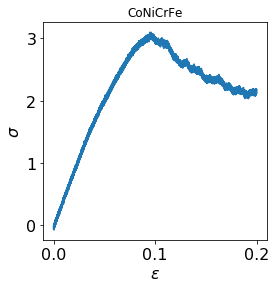

In [231]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\sigma$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title(fileNamee[:-4])
#
ax.plot(stress[:,0],stress[:,1],'-')

#--- point corresponding to strain maps
ADD_POINTS = False
if ADD_POINTS:
    for itime in coord_atoms_broken:
        CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
        volume = np.linalg.det( CellVectorOrtho )
        virial = np.c_[coord_atoms_broken[itime]['c_mystress4']].astype(float).sum() / volume
        #--- strain
        dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
        l1=CellVector[ itime ][1,1]
        strain = 0.5*dx/l1
        ax.plot([2*strain],[virial*1e-4],'x',color='red')
#
plt.savefig(fileNamee[:-4]+'.png',dpi=75,bbox_inches='tight')
plt.show()

# Plastic Deformation
## Dump File

In [232]:
def GetCordsTimeStep(slist):
    slist.readline()
    itime = int( slist.readline().split()[0] )
    
    [slist.readline() for i in xrange(1)]
    nrows = int(slist.readline().split()[0])

    [slist.readline() for i in xrange(1)]
    
    CellVector = np.array([slist.readline().split() for i in xrange( 3 )])
    
    cols = slist.readline().split()[2:]
    
    return np.array([slist.readline().split() for i in xrange( nrows )]), CellVector, itime, cols
    
def GetCords( file_name ):
    slist = open( file_name )    
    coord_atoms_broken = {}
    CellVector = {}
    try:
        while True:
            sarr, cell_vector, itime, cols  = GetCordsTimeStep( slist ) #--- get coord
            #--- insert in a data frame
            coord_atoms_broken[ itime ] = pd.DataFrame( sarr, columns = cols )
            
            #--- cast id to 'int'
            coord_atoms_broken[ itime ]['id'] = map(int,coord_atoms_broken[ itime ]['id'].tolist())[:]

            #--- sort
            coord_atoms_broken[ itime ].sort_values( by = 'id', inplace = True )
            
            #--- reset index
            coord_atoms_broken[ itime ].reset_index( drop=True, inplace=True )
            
            CellVector[ itime ] = cell_vector
    except:
#        traceback.print_exc()
        pass

    
    return coord_atoms_broken, CellVector

def GetCellVector( CellVector ):
    CellVector[0] = np.c_[CellVector[0],['0.0','0.0','0.0']] #--- ref. state

    CellOrigin = {}
    cell_vector = {}
    
    for itime in CellVector:
        row0 = map( float, CellVector[ itime ][ 0 ] )
        l0 = row0[ 1 ] - row0[ 0 ] - row0[ 2 ]
        CellVector0 = np.array( [ l0, 0.0, 0.0 ] )
        dx = row0[ 2 ]
        
        row1 =  map( float, CellVector[ itime ][ 1 ] )
        l1 = row1[ 1 ] - row1[ 0 ]
        a1 = np.array( [ 0.0, l1, 0.0 ] )
        CellVector1 = CellVector0 * ( dx / l0 ) + a1
        
        row2 =  map( float, CellVector[ itime ][ 2 ] )
        l2 = row2[ 1 ] - row2[ 0 ]
        CellVector2 = np.array( [ 0.0, 0.0, l2 ] )
        
        CellOrigin[ itime ] = np.array( [ row0[ 0 ], row1[ 0 ], row2[ 0 ] ] )
        cell_vector[ itime ] = np.c_[ CellVector0, CellVector1, CellVector2 ] 

    return CellOrigin, cell_vector



fileName = ('./BmgData/FeNi_glass.dump',
            './BmgData/CoNiCr_glass.dump',
            './BmgData/CoNiCrFe_glass.dump',
            './BmgData/CoCrFeMn_glass.dump',
            './BmgData/Co5Cr2Fe40Mn27Ni26_glass.dump')[2]#--- parse cords
coord_atoms_broken, cell_vector = GetCords( fileName ) #--- add xyz for broken bonds #--- check id!!1
CellOrigin, CellVector = GetCellVector( cell_vector )

## Compute Displacements


In [233]:
def ChangeBasis( coord_atoms_broken, CellVector, CellOrigin, **kwargs ):
############################################################
####### map atoms within a tilted box to an orthogonal one
############################################################

    DimensionlessCords = GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin  ) #--- beta0, beta1, beta2

    #--- shift (beta0 + beta1 * dx / |b0| > 1) by - b0
    #--- [b0,b1]^{-1}*(x=|b0|,y)
    
    b2 = CellVector[:,2]
    b1 = CellVector[:,1]
    b0 = CellVector[:,0]
    norm_b0 = np.dot(b0,b0)**0.5
    shift0 = np.dot(b1, b0 / norm_b0 )
    #
    indices_shiftTrue = (DimensionlessCords['beta0']) + (DimensionlessCords['beta1'])*shift0/norm_b0 >= 1.0
    n = len( indices_shiftTrue )
    shift_matrix =  np.array(indices_shiftTrue).reshape((n,1)) * b0
    #
    xyz = coord_atoms_broken - shift_matrix
    #
    attr_list = ['x','y','z']
    values = xyz
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
                
    return pd.DataFrame( values, columns = attr_list )

def AddCopies( coord_atoms_broken, CellVector, **kwargs ):    
    #--- orignial cell
    XYZ_shifted = coord_atoms_broken
    xyz_original = XYZ_shifted.copy()
    #---
    attr_list = ['x','y','z']
    values = XYZ_shifted
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]

    ID_TYPE_shifted = values[:,3:]
    id_type_original = ID_TYPE_shifted.copy()
    
    #--- cell copies
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            for k in [-1,0,1]:
    #            print i,j,k
                if i == j == k == 0:
                    continue
                total_shift = np.matmul( CellVector, np.array([i,j,k]) )
                #--- add shift
                xyz_shifted = xyz_original + total_shift
                #--- append
                XYZ_shifted = np.concatenate( ( XYZ_shifted, xyz_shifted ), axis = 0 )
                ID_TYPE_shifted = np.concatenate( ( ID_TYPE_shifted, id_type_original ), axis = 0 )
                                
    return pd.DataFrame(np.c_[XYZ_shifted,ID_TYPE_shifted],columns=attr_list)

def GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin, **kwargs  ):
    xyz_centered = coord_atoms_broken - CellOrigin
    beta = np.matmul( np.linalg.inv(CellVector), xyz_centered.T).T
    
    attr_list = ['beta0', 'beta1', 'beta2']
    values = beta
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
        
    return pd.DataFrame( values, columns = attr_list  )

def shiftBeta( xyzDimensionless_j, diff, key = 'beta0' ):
    indices = diff[key] > 0.5
    beta0_j = xyzDimensionless_j[key] - 1.0 * indices

    indices = diff[key] < -0.5
    beta0_j += 1.0 * indices
    
    return beta0_j

def GetXYZ( CellVector, CellOrigin, DimensionlessCords, attr_list = ['x','y','z'], **kwargs ):
    XYZ_centered = np.matmul( CellVector, DimensionlessCords.T ).T #--- xyz in reference state
    XYZ = XYZ_centered + CellOrigin
    
    
    values = XYZ
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
        
    return pd.DataFrame( values, columns = attr_list)

def EstimateUnwrappedCord( coord_atoms_broken_i, coord_atoms_broken_j,
                           CellVector_i, CellVector_j,
                           CellOrigin_i, CellOrigin_j):
#--- dimensionless cords
    xyzDimensionless_i = GetDimensionlessCords( CellVector_i, coord_atoms_broken_i, CellOrigin_i )
    xyzDimensionless_j = GetDimensionlessCords( CellVector_j, coord_atoms_broken_j, CellOrigin_j )

    #--- shift to get unwrapped cords
    diff = xyzDimensionless_j[['beta0','beta1','beta2']] - xyzDimensionless_i[['beta0','beta1','beta2']]

    #--- new dimensionless cords
    beta0_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta0' )
    beta1_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta1' )
    beta2_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta2' )

    #--- unwrapped cords at deformed state
    rj_unwrpd = GetXYZ( CellVector_j, CellOrigin_j, np.c_[beta0_j,beta1_j,beta2_j] )

    return rj_unwrpd




#--- do mapping & add copies
coord = {}
for itime in coord_atoms_broken:
    #--- map atoms in the ref. state to an undeformed box
    df = coord_atoms_broken[ itime ][['id','type','x','y','z']]
    xyz = np.c_[df[['x','y','z']].astype('float')]
    xyz_mapped = ChangeBasis( xyz, CellVector[ itime ], CellOrigin[ itime ] )

    #--- append
    tmp = pd.DataFrame(np.c_[df, xyz_mapped],columns=['id','type','x','y','z','xm','ym','zm'])
        
    #--- add copies
    df = tmp
    xyz = np.c_[df[['x','y','z']].astype('float')]
    xyz_copy = AddCopies( xyz, CellVector[ itime ],
                          id=df['id'],
                          type = df['type']
                        )
    xyz_m = np.c_[df[['xm','ym','zm']].astype('float')]
    xyz_m_copy = AddCopies( xyz_m, CellVector[ itime ],
                          id=df['id'],
                          type = df['type']
                        )
    coord[itime] = pd.DataFrame(np.c_[xyz_copy[['id','type','x','y','z']],xyz_m_copy[['x','y','z']]],columns=['id','type','x','y','z','xm','ym','zm'])

#---
#--- compute displacements
#---
REF = ('initial', 'previous')[0] #--- displ. with respect to an initial state or previous state

times = coord_atoms_broken.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):   
    if REF == 'initial':
        time_i = 0
    print time_i, time_j
    #--- estimate unwrapped coordinates (deformed state)
    # r^{wrpd}_i, r^{wrpd}_j, r^{unwrpd}_j
    xyz_i = np.c_[coord[time_i][['x','y','z']]].astype('float')
    xyz_j = np.c_[coord[time_j][['x','y','z']]].astype('float')
    rj_unwrpd = EstimateUnwrappedCord( xyz_i, xyz_j,
                                       CellVector[time_i], CellVector[time_j],
                                       CellOrigin[time_i], CellOrigin[time_j] )    
    #--- displacement: r^{unwrpd}_j - r^{wrpd}_i
    disp = rj_unwrpd[['x','y','z']] - xyz_i
        
    #--- append (xm,ym,zm) denoting mapped coordinates
    df = coord[ time_j ]
    coord[ time_j ] = pd.DataFrame(np.c_[df, disp],columns=['id','type','x','y','z','xm','ym','zm','ux','uy','uz'])


    
    

0 500000
0 1000000
0 1500000
0 2000000


### Print

In [234]:
def GetOrthogonalBasis( CellVector ): 
    a0 = CellVector[:,0]
    l0 = np.dot(a0,a0)**0.5
    n0 = a0 / l0 
    #
    a1 = CellVector[:,1]
    a1_perp = a1 - np.dot( a1, n0 ) * n0
    l1 = np.dot( a1_perp, a1_perp) ** 0.5
    #
    a2 = CellVector[:,2]
    l2 = np.dot(a2,a2)**0.5
    
    return np.c_[a0, a1_perp, a2], [l0, l1, l2]

def GetPoints( CellOrigin, CellVector, xyz, ev = 0.2, output_attr = ['x','y','z'],**kwargs ):
    
    #--- tensor associated with dilation
    strainTensor = np.array([[ev/3.0,0,0],
                            [0,ev/3.0,0],
                            [0,0,ev/3.0]])
    #
    identityMat = np.array([[1,0,0],[0,1,0],[0,0,1]])
    #
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )

    #--- extend diagonal
    rvect = -np.matmul( CellVectorOrtho, np.array([0.5,0.5,0.5]))
    CellOrigin_expanded = CellOrigin + np.matmul(strainTensor,rvect)

    #--- extend basis vectors
    CellVector_expanded = np.matmul( identityMat + strainTensor, CellVectorOrtho )

    #--- (beta0,beta1,beta2) associated with original atoms and their images 
    #--- with reference to the expanded box 
    DimensionlessCords = GetDimensionlessCords( CellVector_expanded, 
                                                xyz,
                                                CellOrigin_expanded,
                                                **kwargs )
    #--- filter: only inside the expanded box 
    index0 = np.all([DimensionlessCords['beta0'] >= 0.0, DimensionlessCords['beta0'] < 1.0], axis=0 )
    index1 = np.all([DimensionlessCords['beta1'] >= 0.0, DimensionlessCords['beta1'] < 1.0], axis=0 )
    index2 = np.all([DimensionlessCords['beta2'] >= 0.0, DimensionlessCords['beta2'] < 1.0], axis=0 )
    bete_inside = DimensionlessCords[np.all([index0,index1,index2],axis=0)]

    #--- xyz coordinates
    kwargss = {}
    for keys in kwargs:
        kwargss[ keys ] = bete_inside[ keys ]        
    xyz_inside = GetXYZ( CellVector_expanded, CellOrigin_expanded, 
                         np.c_[bete_inside[['beta0','beta1','beta2']]],
                         output_attr,
                         **kwargss )
    
    return xyz_inside

def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()



#--- print 
file_name = 'displ.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass

times = coord.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):   
    if REF == 'initial':
        time_i = 0
    #--- get a chunck of full copies
    df_i = coord[ time_i ]
    df_j = coord[ time_j ]

    df_chunk =  GetPoints( CellOrigin[ time_i ], 
                               CellVector[ time_i ],
                               np.c_[df_i[['xm','ym','zm']]].astype('float'), #--- give mapped coordinates
                               ev = 0.3,
                               output_attr = ['xm','ym','zm'],
                               id = df_i['id'],
                               type = df_i['type'],
                               x = df_i['x'],
                               y = df_i['y'],
                               z = df_i['z'],
                               ux = df_j['ux'],
                               uy = df_j['uy'],
                               uz = df_j['uz'],
                             )
    

    PrintOvito( df_chunk, 
                open(file_name,'a'), 
                footer = 'ITIME=%s'%time_j,
                attr_list=['id','type','xm','ym','zm','ux','uy','uz'] )



## Gradients

### Interpolate Displacements
#### cubic grid

In [235]:
def GetCubicGrid( CellOrigin, CellVector, dmean, margin  ):

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    
    volume = np.linalg.det( CellVectorOrtho )


    [nx, ny, nz] = map( int, (np.array(VectorNorm)+2*margin) / dmean )
    if nx%2 == 0:
        nx += 1
    if ny%2 == 0:
        ny += 1
    if nz%2 == 0:
        nz += 1
    
    x = np.linspace( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin, nx,endpoint=False)
    y = np.linspace( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin, ny,endpoint=False)
    z = np.linspace( CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin, nz,endpoint=False)

    return (x, y, z), np.meshgrid(x, y,z)



#--- mean dist between atoms 
natoms = len( coord_atoms_broken[ 0 ] ) 
CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ 0 ] )
volume = np.linalg.det( CellVectorOrtho )
dmean = 0.5 * ( volume / natoms ) ** (1.0/3.0) 

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = GetCubicGrid( CellOrigin[ 0 ], 
                                                 CellVector[ 0 ], 
                                                 dmean,
                                                 margin = 0.0 )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))


#### center box + margin

In [236]:
df_intrp = {}
times = coord.keys()
times.sort()
for time_i, time_j in zip(times[:-1], times[1:]):   
    if REF == 'initial':
        time_i = 0
    #--- get a chunck of full copies
    df_i = coord[ time_i ]
    df_j = coord[ time_j ]
    
    #--- get points from which values are interpolated
    pointsValues =  GetPoints( CellOrigin[ time_i ], 
                               CellVector[ time_i ],
                               np.c_[df_i[['xm','ym','zm']]].astype('float'), #--- give mapped coordinates
                               ev = 0.3,
                               output_attr = ['xm','ym','zm'],
                               id = df_i['id'],
                               type = df_i['type'],
                               x = df_i['x'],
                               y = df_i['y'],
                               z = df_i['z'],
                               ux = df_j['ux'],
                               uy = df_j['uy'],
                               uz = df_j['uz'],
                             )
        
    #--- interpolate
    points = pointsValues[['xm','ym','zm']]
    values = pointsValues[['ux','uy','uz']]
    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'
    
    #--- store in dataframe
    df_intrp[ time_j ] = pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','ux','uy','uz'])


#### Print

In [131]:
file_name = 'intrp.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass

for itime in df_intrp:
    PrintOvito( df_intrp[ itime ], 
                    open( file_name,'a'), 
                    footer = 'ITIME=%s'%itime,
                    attr_list=['x','y','z','ux','uy','uz'] )


### Strain tensor

In [237]:
def GetStrain( value, (xlin,ylin,zlin), (xv,yv,zv)):
    #--- reshape matrix
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    ux = np.c_[value['ux']].reshape((ny,nx,nz))
    uy = np.c_[value['uy']].reshape((ny,nx,nz))
    uz = np.c_[value['uz']].reshape((ny,nx,nz))

    #--- gradient
    ux_x = np.gradient(ux,xlin,axis=1)
    ux_y = np.gradient(ux,ylin,axis=0)
    ux_z = np.gradient(ux,zlin,axis=2)

    uy_x = np.gradient(uy,xlin,axis=1)
    uy_y = np.gradient(uy,ylin,axis=0)
    uy_z = np.gradient(uy,zlin,axis=2)

    uz_x = np.gradient(uz,xlin,axis=1)
    uz_y = np.gradient(uz,ylin,axis=0)
    uz_z = np.gradient(uz,zlin,axis=2)

    #--- strain
    exx = ux_x
    exy = 0.5 * ( ux_y + uy_x )
    exz = 0.5 * ( ux_z + uz_x )

    eyx = exy
    eyy = uy_y
    eyz = 0.5 * ( uy_z + uz_y )

    ezx = exz
    ezy = eyz
    ezz = uz_z
    
    #--- subtract mean
    exx -= np.mean(exx)
    exy -= np.mean(exy)
    exz -= np.mean(exz)

    eyx -= np.mean(eyx)
    eyy -= np.mean(eyy)
    eyz -= np.mean(eyz)

    ezx -= np.mean(ezx)
    ezy -= np.mean(ezy)
    ezz -= np.mean(ezz)
    
    return pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),
                 exx.flatten(), eyy.flatten(), ezz.flatten(), 
                 exy.flatten(), eyz.flatten(), ezx.flatten()], 
                 columns = ['x','y','z','exx','eyy','ezz','exy','eyz','ezx'])

Strain = {}
for itime in df_intrp:
    Strain[itime] = GetStrain(df_intrp[ itime ], (xlin,ylin,zlin), (xv,yv,zv))


#### imshow

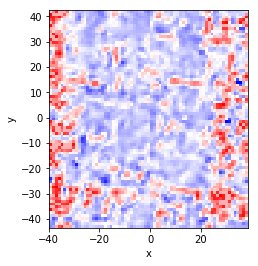

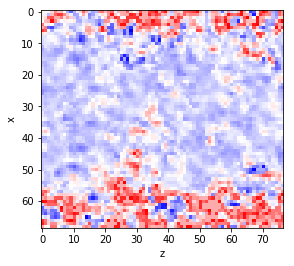

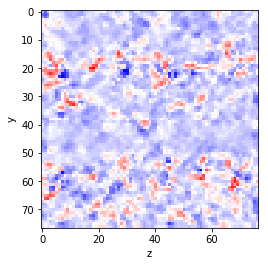

In [238]:
itime = 2000000

nx,ny,nz = len(xlin), len(ylin),len(zlin) 
value = np.c_[Strain[itime]['exy']].reshape(((ny,nx,nz)))


val = value.copy()
val -= np.mean(val)
val /= np.std(val)
val[val>3.0]=1.0
val[val<-3.0]=-1.0
#
plt.xlabel('x')
plt.ylabel('y')
plt.imshow((CenterMatrix( val[:,:,0] ).real),cmap='bwr',extent=(xlin.min(),xlin.max(),ylin.min(),ylin.max())) #,vmin=-.01, vmax=.01)
plt.show()
#
plt.xlabel('z')
plt.ylabel('x')
plt.imshow((CenterMatrix( val[0,:,:] ).real),cmap='bwr') #,vmin=-.01, vmax=.01)
plt.show()
#
plt.xlabel('z')
plt.ylabel('y')
plt.imshow((CenterMatrix( val[:,0,:] ).real),cmap='bwr') #,vmin=-.01, vmax=.01)
plt.show()

In [239]:
(nx,ny,nz)

(69, 77, 77)

#### Print

In [140]:
file_name = 'strain.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass
    
times = Strain.keys()
times.sort()
for itime in times:
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1

    
    PrintOvito( Strain[ itime ], 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','exx','eyy','ezz','exy','eyz','ezx'] )
    

In [240]:
itime = 4*500000
nx,ny,nz = len(xlin), len(ylin),len(zlin) 
value = np.c_[Strain[itime]['exy']].reshape(((ny,nx,nz)))

value -= np.mean( value )
value /= np.std( value )

n = nx * ny * nz
vq = np.fft.fftn(value) #, axes=(0,1,2))
vq_sq = np.abs(vq)**2

v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )

#xgrid = np.c_[Strain[itime]['x']].reshape(((ny,nx,nz)))
#ygrid = np.c_[Strain[itime]['y']].reshape(((ny,nx,nz)))
#zgrid = np.c_[Strain[itime]['z']].reshape(((ny,nx,nz)))

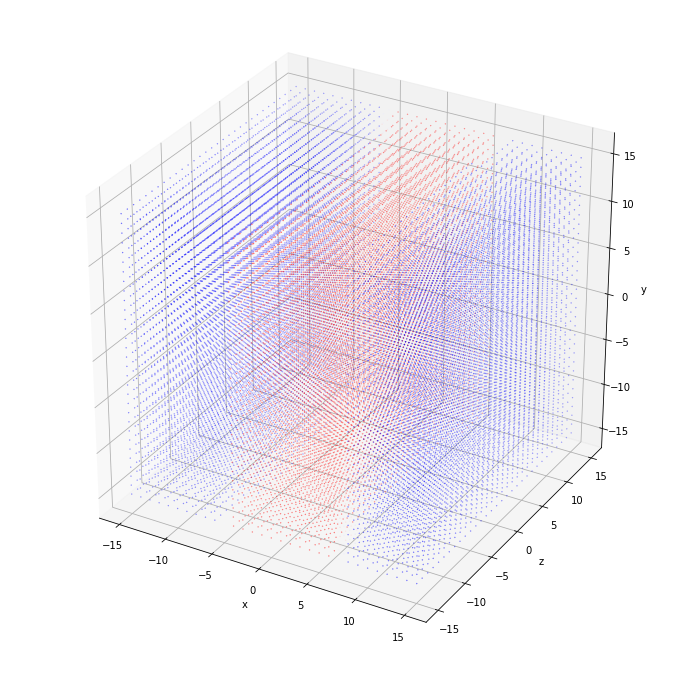

In [135]:
def CenterMatrix3d(a):
    ( mgrid, ngrid, kgrid ) = a.shape
    return np.array([[[ a[ i,j, k] for k in xrange(-(kgrid/2)-kgrid%2,kgrid/2)] 
                                    for j in xrange(-(ngrid/2)-ngrid%2,ngrid/2)] 
                                    for i in xrange(-(mgrid/2)-mgrid%2,mgrid/2) ])

def plot3dEshelby(CellVector, p_real):

    (mgrid,ngrid,kgrid) = p_real.shape

#    print '(ny,nx,nz)=',p_real.shape
    
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    
    
    x = np.arange(-(ngrid/2),ngrid/2+ngrid%2)
#     indices = np.all([x>=-5.0, x <= 5.0],axis=0)
#     nx = len(x[indices])
    
    y = np.arange(-(mgrid/2),mgrid/2+mgrid%2)
#     indices = np.all([y>=-5.0, y <= 5.0],axis=0)
#     ny = len(y[indices])

    z = np.arange(-(kgrid/2),kgrid/2+kgrid%2)
#     indices = np.all([z>=-5.0, z <= 5.0],axis=0)
#     nz = len(z[indices])

    
    xv, yv, zv = np.meshgrid(x,y,z)#,indexing='xy')
#    print xv.shape
    ncut = 30 / 2
    indices = np.all([xv <= ncut,xv >= -ncut, 
                      yv <= ncut,yv >= -ncut,
                      zv <= ncut,zv >= -ncut ],axis=0)
    xvf = xv[indices]#.flatten()
    yvf = yv[indices]#.flatten()
    zvf = zv[indices]#.flatten()

    
    
    val = CenterMatrix3d(p_real).real #.flatten()
#    print val.shape

    valf = val[indices]
#    print valf.min()
    
    valf -= np.mean(valf)
    valf /= np.std(valf)
    valf[valf>.2]=1.0
    valf[valf<-.2]=-1.0
    
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    
#    print indices.shape, xv[indices]
#    print VectorNorm,xvf.min()#,zvf.shape#,valf.shape
     #.flatten()
    #
    
    ax.scatter(xvf,zvf,yvf,
               c=valf, cmap='bwr',
               s=.1,zorder=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')

    #fig.colorbar(img)
    
    
            #--- projectio
#     xflat = np.full_like(xv.flatten(), min(ax.get_xlim()))
#     yflat = np.full_like(yv.flatten(), max(ax.get_ylim()))
#     zflat = np.full_like(zv.flatten(), min(ax.get_zlim()))
    
#     ax.scatter(xflat, zv.flatten(), yv.flatten(),c=val,s=.1,cmap='bwr',zorder=2)
#     ax.scatter(xv.flatten(), zflat, yv.flatten(),c=val,s=.1,cmap='bwr',zorder=2)
#     ax.scatter(xv.flatten(), zv.flatten(), yflat,c=val,s=.1, cmap='bwr',zorder=2)
            
    plt.show()
    
plot3dEshelby( CellVector[itime], v_real.real )

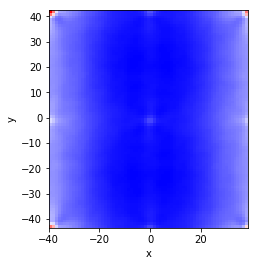

In [281]:
def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[ a[i,j] for j in xrange(-(ngrid/2),ngrid/2+ngrid%2)] 
                              for i in xrange(-(mgrid/2),mgrid/2+mgrid%2)])


val = v_real.copy()
# val -= np.mean(val)
# val /= np.std(val)
# val[val>3.0]=1.0
# val[val<-3.0]=-1.0
if 1:#dim == 3:
    plt.xlabel('x')
    plt.ylabel('y')
    plt.imshow((( val[:,:,0] ).real),cmap='bwr',extent=(xlin.min(),xlin.max(),ylin.min(),ylin.max())) #,vmin=-.01, vmax=.01)
    plt.show()
    #
#     plt.xlabel('z')
#     plt.ylabel('x')
#     plt.imshow((CenterMatrix( val[0,:,:] ).real),cmap='bwr') #,vmin=-.01, vmax=.01)
#     plt.show()
#     #
#     plt.xlabel('z')
#     plt.ylabel('y')
#     plt.imshow((CenterMatrix( val[:,0,:] ).real),cmap='bwr') #,vmin=-.01, vmax=.01)
#     plt.show()

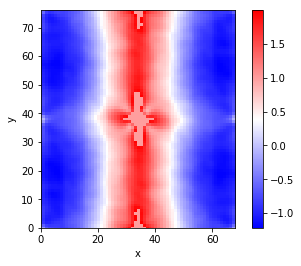

In [284]:
val = v_real[:,:,0].copy()
val -= np.mean(val)
val /= np.std(val)
val[val>2.0]=1.0
val[val<-2.0]=-1.0
(mgrid,ngrid) = val.shape
center = (ngrid/2,mgrid/2)
if 1:#dim == 3:
    frac = 1.0 #0.6
    plt.xlabel('x')
    plt.ylabel('y')
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr') #,extent=(xlin.min(),xlin.max(),ylin.min(),ylin.max())) #,vmin=-.01, vmax=.01)
    plt.xlim(center[0]-(ngrid/2)*frac,center[0]+(ngrid/2)*frac)
    plt.ylim(center[1]-(mgrid/2)*frac,center[1]+(mgrid/2)*frac)
    plt.colorbar( pos, fraction = 0.04)
#    plt.ylim((-(mgrid/2)-mgrid%2)*frac,(mgrid/2)*frac)
#    plt.ylim(ylin.min()*frac,ylin.max()*frac)
    plt.show()


In [277]:
val.min()

(-0.1325165367744197+2.337266651169305e-18j)

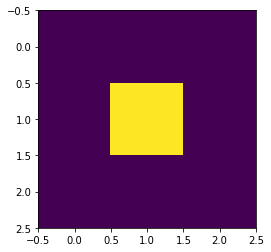

In [256]:
a=np.array([[0,0,0],[0,1,0],[0,0,0]])
plt.imshow(a)
plt.show()

In [250]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, hold=None, data=None, **kwargs)
    Display an image on the axes.
    
    Parameters
    ----------
    X : array_like, shape (n, m) or (n, m, 3) or (n, m, 4)
        Display the image in `X` to current axes.  `X` may be an
        array or a PIL image. If `X` is an array, it
        can have the following shapes and types:
    
        - MxN -- values to be mapped (float or int)
        - MxNx3 -- RGB (float or uint8)
        - MxNx4 -- RGBA (float or uint8)
    
        MxN arrays are mapped to colors based on the `norm` (mapping
        scalar to scalar) and the `cmap` (mapping the normed scalar to
        a color).
    
        Elements of RGB and RGBA arrays represent pixels of an MxN image.
        All values should be in the 